# 9章：RNN, CNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/NLP100knock2024/chapter09/'

/content/drive/MyDrive/NLP100knock2024/chapter09


## 80. ID番号への変換

In [3]:
import pandas as pd
from collections import defaultdict
import string


class ID():
    def __init__(self, data):
        #単語と出現頻度を入れる辞書
        self.train_dict = defaultdict(int)
        #単語とIDを入れるリスト
        self.id_list = []
        #単語とIDを入れる辞書
        self.id_dict = dict()
        self.make_id(data)

    def make_id(self, data):
        #dataの単語をカウントした辞書を作る
        for line in data:
            words = line.translate(table).split()
            for word in words:
                # if word != "":
                self.train_dict[word] += 1
        calc_dict = dict(self.train_dict)
        #出現回数で降順にする
        sort_list = sorted(calc_dict.items(), key=lambda x: x[1], reverse=True)
        for i, (trg_word, freq) in enumerate(sort_list):
            #２回以上出現
            if freq >= 2:
                #単語とIDのタプルを入れる。
                self.id_list.append((trg_word, i+1))
            #１回のみ出現
            else:
                self.id_list.append((trg_word, 0))
        self.id_dict = dict(self.id_list)

    def return_id(self, line):
        """ある単語列について単語に分割し、その単語にIDがあればID、そうでなければ0にしたものを返す"""
        one_hot_vec = []
        words = line.strip().split(" ")
        for word in words:
            if word in self.id_dict.keys():
                one_hot_vec.append(self.id_dict[word])
            else:
                one_hot_vec.append(0)
        return one_hot_vec


In [4]:
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))

header_name = ['TITLE', 'CATEGORY']
train_file = "../chapter06/train.txt"
train_data = pd.read_csv(train_file, header=None,
                         sep='\t', names=header_name)
w2id = ID(train_data['TITLE'])
test_vec = w2id.return_id(train_data["TITLE"][10])


# print(test_vec)
print(w2id.id_dict)

{'to': 1, 's': 2, 'in': 3, 'UPDATE': 4, 'on': 5, 'as': 6, 'US': 7, 'for': 8, 'of': 9, 'The': 10, '1': 11, 'To': 12, '2': 13, 'and': 14, 'the': 15, 'In': 16, 'Of': 17, 'at': 18, 'a': 19, 'A': 20, 'Is': 21, 'With': 22, 'For': 23, 'with': 24, 'And': 25, 'after': 26, '3': 27, 'New': 28, 'Kardashian': 29, 'China': 30, 'On': 31, 'by': 32, 'up': 33, 'Kim': 34, 'After': 35, 'At': 36, 'says': 37, 'is': 38, 'From': 39, 'STOCKS': 40, 'ECB': 41, 't': 42, 'Fed': 43, 'from': 44, 'Says': 45, 'new': 46, '4': 47, 'her': 48, 'Wall': 49, 'shares': 50, 'FOREX': 51, 'Euro': 52, 'data': 53, 'It': 54, 'Cyrus': 55, 'First': 56, 'Miley': 57, 'CEO': 58, '5': 59, 'Dollar': 60, 'West': 61, 'May': 62, 'over': 63, 'Google': 64, 'About': 65, 'St': 66, 'she': 67, 'You': 68, 'S': 69, 'Kanye': 70, 'Up': 71, 'Ukraine': 72, 'bln': 73, 'Over': 74, 'Chris': 75, 'As': 76, 'Stocks': 77, 'Be': 78, 'off': 79, 'More': 80, 'Will': 81, 'I': 82, 'Billion': 83, 'Justin': 84, 'Apple': 85, 'Bank': 86, 'Bieber': 87, 'UK': 88, 'euro': 

## 81. RNNによる予測

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset


class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size):
        super().__init__()
        self.hid_size = hidden_size
        #単語の埋め込み
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx) #vocab_size:語彙サイズ、emb_size:埋め込み次元、padding_idx：無視するID
        #RNNを構築
        self.rnn = nn.RNN(emb_size, hidden_size, #input_size:入力サイズ、hidden_size:隠れ層hにおける特徴量数
                          nonlinearity="tanh", batch_first=True) #nonlinearity:非線形変換、batch_first:入出力の最初をbatchにする
        #出力
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(1, self.batch_size, self.hid_size)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out


class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)

    #token化してテンソルにしたinputとlabelの辞書を返す
    def __getitem__(self, idx):
        text = self.x[idx]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[idx], dtype=torch.int64)
        }


In [8]:
train = pd.read_csv("../chapter08/train.txt", sep='\t')
valid = pd.read_csv("../chapter08/valid.txt", sep='\t')
test = pd.read_csv("../chapter08/test.txt", sep='\t')


category = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category[x]).values)


dataset_train = NewsDataset(train["TITLE"], y_train, w2id.return_id)
dataset_valid = NewsDataset(valid["TITLE"], y_valid, w2id.return_id)
dataset_test = NewsDataset(test["TITLE"], y_test, w2id.return_id)


print(f'len(Dataset): {len(dataset_train)}')
print('Dataset[index]:')
for var in dataset_train[1]:
    print(f'  {var}: {dataset_train[1][var]}')

len(Dataset): 10684
Dataset[index]:
  inputs: tensor([  70,   61,    0,   70,   61, 5132,   36, 1443,  404])
  labels: 2


<ipython-input-7-5f162c53d092>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


In [9]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE)
for i in range(10):
    X = dataset_train[i]['inputs']
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1)) #unsqueezeで次元0に新しい次元を挿入

tensor([[0.1924, 0.4923, 0.1445, 0.1708]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2240, 0.2021, 0.3075, 0.2664]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1385, 0.3959, 0.1693, 0.2963]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3230, 0.1715, 0.2979, 0.2077]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1380, 0.3961, 0.1672, 0.2987]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1835, 0.1853, 0.2529, 0.3783]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1889, 0.2861, 0.3381, 0.1868]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1158, 0.4938, 0.1620, 0.2284]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1137, 0.4241, 0.2529, 0.2093]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1292, 0.2694, 0.2700, 0.3314]], grad_fn=<SoftmaxBackward0>)


<ipython-input-7-5f162c53d092>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


## 82. 確率的勾配降下法による学習

In [10]:
import numpy as np
from matplotlib import pyplot as plt
import time
from torch.utils.data import DataLoader


def calc_loss_acc(model, dataset, device=None, criterion=None):
    # model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            #GPUがつかえるなら
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)

            if criterion != None:
                loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion,  optimizer, num_epochs, device=None):

    model.to(device)

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=1, shuffle=False)
    # dataloader_valid = DataLoader(
    #     dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()
        #訓練モード
        model.train()
        loss_train = 0.0
        for data in dataloader_train:
            optimizer.zero_grad()
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        #検証モード
        model.eval()
        loss_train, acc_train = calc_loss_acc(
            model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_acc(
            model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, train_time: {(end_time - start_time):.4f}sec')
    return {
        "train": log_train,
        "valid": log_valid
    }


def visualize_logs(log, number):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.savefig(f"{number}.png")


<ipython-input-7-5f162c53d092>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.0818, accuracy_train: 0.5528, loss_valid: 1.1083, accuracy_valid: 0.5509, train_time: 42.7971sec
epoch: 2, loss_train: 1.0174, accuracy_train: 0.6003, loss_valid: 1.0586, accuracy_valid: 0.5771, train_time: 42.9640sec
epoch: 3, loss_train: 0.9507, accuracy_train: 0.6402, loss_valid: 1.0405, accuracy_valid: 0.5981, train_time: 40.7743sec
epoch: 4, loss_train: 0.7797, accuracy_train: 0.7245, loss_valid: 0.8660, accuracy_valid: 0.6924, train_time: 40.6953sec
epoch: 5, loss_train: 0.6856, accuracy_train: 0.7554, loss_valid: 0.7878, accuracy_valid: 0.7246, train_time: 40.9449sec
epoch: 6, loss_train: 0.6077, accuracy_train: 0.7814, loss_valid: 0.7375, accuracy_valid: 0.7418, train_time: 40.7965sec
epoch: 7, loss_train: 0.6111, accuracy_train: 0.7751, loss_valid: 0.7863, accuracy_valid: 0.7081, train_time: 43.2719sec
epoch: 8, loss_train: 0.5125, accuracy_train: 0.8092, loss_valid: 0.7181, accuracy_valid: 0.7283, train_time: 43.2210sec
epoch: 9, loss_train: 0.5080, ac

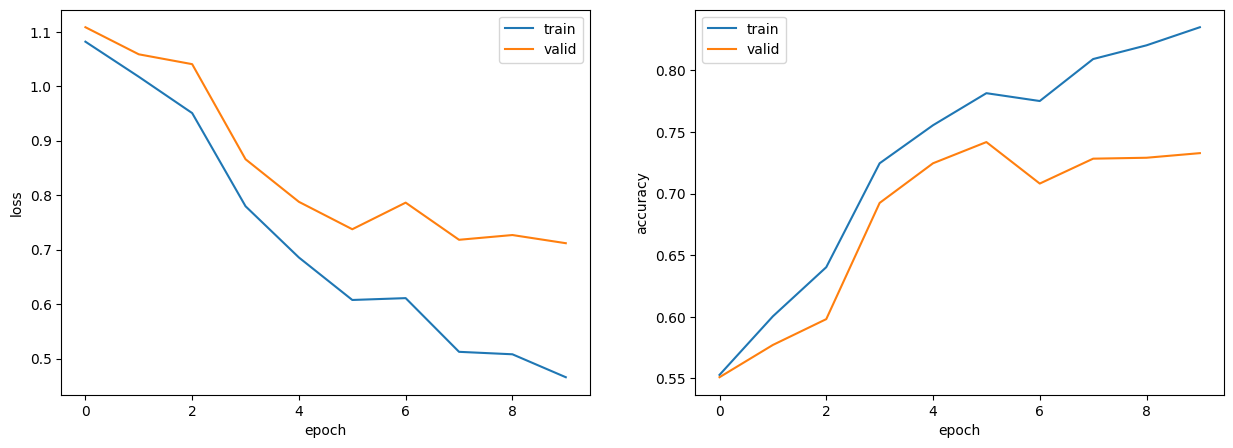

In [11]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
log = train_model(dataset_train, dataset_valid, BATCH_SIZE,
                  model, criterion, optimizer, NUM_EPOCHS)
visualize_logs(log, 82)
_, acc_train = calc_loss_acc(model, dataset_train)
_, acc_test = calc_loss_acc(model, dataset_test)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')

## 83. ミニバッチ化・GPU上での学習

In [12]:
class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device): #deviceを追加
        super().__init__()
        self.hid_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(emb_size, hidden_size,
                          nonlinearity="tanh", batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(1, self.batch_size, self.hid_size, device=device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out


def train_model(dataset_train, dataset_valid, batch_size, model, criterion,  optimizer, num_epochs, device=None, collate_fn=None): #batch_size, divice, collate_fnを追加
    model.to(device)

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=1, shuffle=False)
    # dataloader_valid = DataLoader(
    #     dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        model.eval()
        loss_train, acc_train = calc_loss_acc(
            model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_acc(
            model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, train_time: {(end_time - start_time):.4f}sec')
    return {
        "train": log_train,
        "valid": log_valid
    }

#可変長のシーケンスデータをパディングして同じ長さに揃える
class Padseq():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(
            batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(
            sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

<ipython-input-7-5f162c53d092>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.2232, accuracy_train: 0.4645, loss_valid: 1.2552, accuracy_valid: 0.4491, train_time: 2.4213sec
epoch: 2, loss_train: 1.2074, accuracy_train: 0.4839, loss_valid: 1.2489, accuracy_valid: 0.4618, train_time: 1.1224sec
epoch: 3, loss_train: 1.1990, accuracy_train: 0.4708, loss_valid: 1.2269, accuracy_valid: 0.4528, train_time: 0.9690sec
epoch: 4, loss_train: 1.1958, accuracy_train: 0.4661, loss_valid: 1.2121, accuracy_valid: 0.4491, train_time: 0.9899sec
epoch: 5, loss_train: 1.1205, accuracy_train: 0.5512, loss_valid: 1.1520, accuracy_valid: 0.5382, train_time: 0.9713sec
epoch: 6, loss_train: 1.2038, accuracy_train: 0.5090, loss_valid: 1.2483, accuracy_valid: 0.4903, train_time: 1.2349sec
epoch: 7, loss_train: 0.9713, accuracy_train: 0.6695, loss_valid: 1.0001, accuracy_valid: 0.6542, train_time: 0.9801sec
epoch: 8, loss_train: 0.9351, accuracy_train: 0.6845, loss_valid: 0.9799, accuracy_valid: 0.6617, train_time: 0.9743sec
epoch: 9, loss_train: 0.8970, accuracy_t

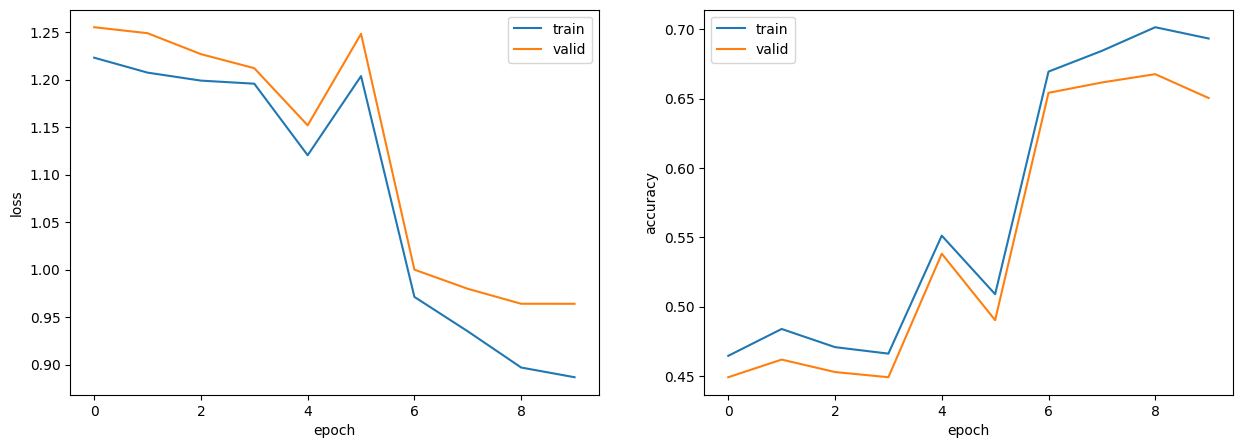

In [13]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

device = torch.device('cuda')


model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE,
            PADDING_IDX, OUTPUT_SIZE, device)

criterion = nn.CrossEntropyLoss()

#確率的勾配降下法を最適化手法に用いる
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion,
                  optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

visualize_logs(log, 83)
_, acc_train = calc_loss_acc(model, dataset_train, device)
_, acc_test = calc_loss_acc(model, dataset_test, device)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')

## 84. 単語ベクトルの導入

In [14]:
#事前学習済み単語ベクトルで単語埋め込みを初期化
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(
    '../chapter07/GoogleNews-vectors-negative300.bin.gz', binary=True)

VOCAB_SIZE = len(set(w2id.id_dict.keys())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(w2id.id_dict.keys()):
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'learned word num: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

learned word num: 16349 / 17056
torch.Size([17056, 300])


<ipython-input-7-5f162c53d092>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.3466, accuracy_train: 0.4145, loss_valid: 1.3987, accuracy_valid: 0.3975, train_time: 2.1878sec
epoch: 2, loss_train: 1.1740, accuracy_train: 0.5273, loss_valid: 1.1956, accuracy_valid: 0.5037, train_time: 0.9735sec
epoch: 3, loss_train: 1.3741, accuracy_train: 0.4437, loss_valid: 1.4464, accuracy_valid: 0.4222, train_time: 0.9889sec
epoch: 4, loss_train: 1.2166, accuracy_train: 0.5191, loss_valid: 1.2580, accuracy_valid: 0.4873, train_time: 0.9783sec
epoch: 5, loss_train: 1.1850, accuracy_train: 0.5562, loss_valid: 1.2481, accuracy_valid: 0.5217, train_time: 1.3291sec
epoch: 6, loss_train: 1.0926, accuracy_train: 0.6058, loss_valid: 1.1332, accuracy_valid: 0.5883, train_time: 0.9971sec
epoch: 7, loss_train: 1.0992, accuracy_train: 0.6055, loss_valid: 1.1613, accuracy_valid: 0.5636, train_time: 1.0429sec
epoch: 8, loss_train: 1.0601, accuracy_train: 0.6246, loss_valid: 1.1201, accuracy_valid: 0.5943, train_time: 0.9834sec
epoch: 9, loss_train: 1.0392, accuracy_t

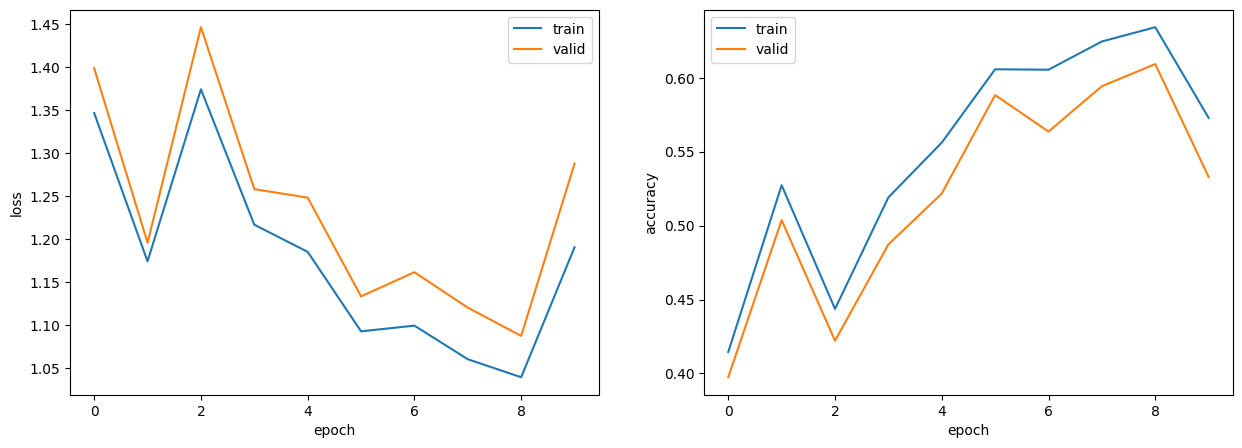

In [15]:
class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False): #emb_weight, bidirectionalを追加
        super().__init__()
        self.hid_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        if emb_weight != None:
            self.emb = nn.Embedding.from_pretrained(
                emb_weight, padding_idx=pad_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        # self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers,
                          nonlinearity="tanh", batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(self.num_layers * self.num_directions,
                             self.batch_size, self.hid_size, device=device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out


VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

device = torch.device('cuda')

# def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False):
model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX,
            OUTPUT_SIZE, device, NUM_LAYERS, emb_weight=weights) #emb_weightsにweightsを指定

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion,
                  optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

visualize_logs(log, 84)
_, acc_train = calc_loss_acc(model, dataset_train, device)
_, acc_test = calc_loss_acc(model, dataset_test, device)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')

## 85. 双方向RNN・多層化

<ipython-input-7-5f162c53d092>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.2956, accuracy_train: 0.4172, loss_valid: 1.3429, accuracy_valid: 0.4057, train_time: 1.1067sec
epoch: 2, loss_train: 1.3011, accuracy_train: 0.4226, loss_valid: 1.3565, accuracy_valid: 0.4079, train_time: 1.4074sec
epoch: 3, loss_train: 1.2352, accuracy_train: 0.4116, loss_valid: 1.2742, accuracy_valid: 0.4057, train_time: 1.4615sec
epoch: 4, loss_train: 1.1910, accuracy_train: 0.5216, loss_valid: 1.2541, accuracy_valid: 0.4865, train_time: 1.0894sec
epoch: 5, loss_train: 1.3927, accuracy_train: 0.4540, loss_valid: 1.4637, accuracy_valid: 0.4386, train_time: 1.1153sec
epoch: 6, loss_train: 1.3247, accuracy_train: 0.4588, loss_valid: 1.3895, accuracy_valid: 0.4379, train_time: 1.0850sec
epoch: 7, loss_train: 1.2202, accuracy_train: 0.5182, loss_valid: 1.3051, accuracy_valid: 0.4873, train_time: 1.1175sec
epoch: 8, loss_train: 1.1717, accuracy_train: 0.5221, loss_valid: 1.2246, accuracy_valid: 0.4970, train_time: 1.0951sec
epoch: 9, loss_train: 1.1335, accuracy_t

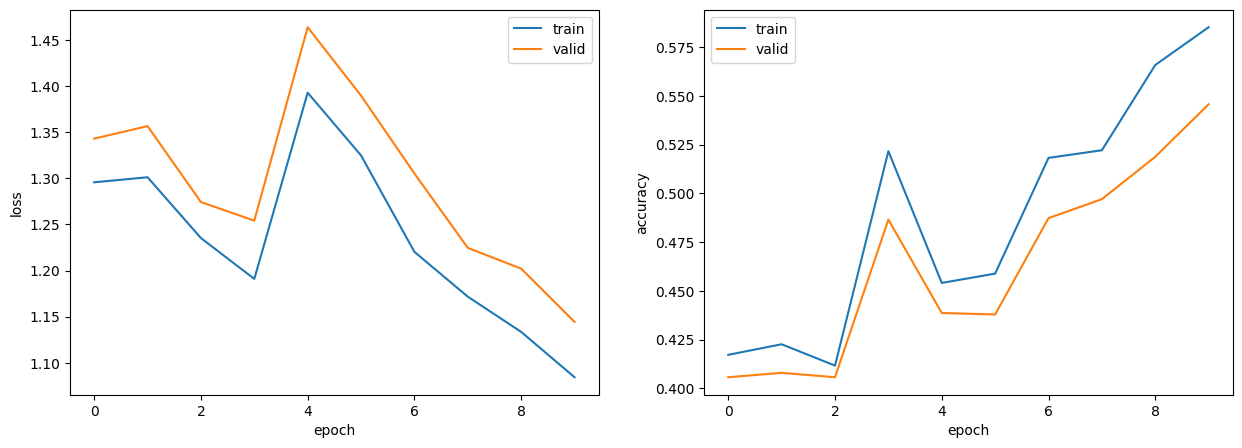

In [16]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

device = torch.device('cuda')

# def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False):
model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE,
            device, NUM_LAYERS, emb_weight=weights, bidirectional=True) #bidirectionalをTrueに

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion,
                  optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

visualize_logs(log, 85)
_, acc_train = calc_loss_acc(model, dataset_train, device)
_, acc_test = calc_loss_acc(model, dataset_test, device)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')

#多層化は実験せず

## 86. 畳み込みニューラルネットワーク (CNN)

In [17]:
from torch.nn import functional as F
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:
          self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
          self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self,x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = F.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        out = self.fc(self.drop(max_pool.squeeze(2)))
        return out

In [18]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2383, 0.2598, 0.2362, 0.2657]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2249, 0.2613, 0.2464, 0.2674]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2672, 0.2353, 0.2373, 0.2602]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2512, 0.2755, 0.2238, 0.2495]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2450, 0.2613, 0.2294, 0.2643]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2180, 0.2329, 0.2587, 0.2905]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2757, 0.2232, 0.2087, 0.2925]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2521, 0.2261, 0.2362, 0.2857]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2616, 0.2421, 0.2267, 0.2697]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2392, 0.2231, 0.2767, 0.2610]], grad_fn=<SoftmaxBackward0>)


<ipython-input-7-5f162c53d092>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


## 87. 確率的勾配降下法によるCNNの学習

<ipython-input-7-5f162c53d092>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.1308, accuracy_train: 0.4905, loss_valid: 1.1519, accuracy_valid: 0.4738, train_time: 1.3234sec
epoch: 2, loss_train: 1.1127, accuracy_train: 0.5475, loss_valid: 1.1323, accuracy_valid: 0.5210, train_time: 0.6146sec
epoch: 3, loss_train: 1.0826, accuracy_train: 0.5203, loss_valid: 1.1117, accuracy_valid: 0.4985, train_time: 0.6041sec
epoch: 4, loss_train: 1.0218, accuracy_train: 0.5811, loss_valid: 1.0563, accuracy_valid: 0.5606, train_time: 0.6084sec
epoch: 5, loss_train: 0.9744, accuracy_train: 0.6112, loss_valid: 1.0211, accuracy_valid: 0.5868, train_time: 0.6011sec
epoch: 6, loss_train: 0.9218, accuracy_train: 0.6356, loss_valid: 0.9816, accuracy_valid: 0.6040, train_time: 0.8206sec
epoch: 7, loss_train: 0.8617, accuracy_train: 0.6750, loss_valid: 0.9343, accuracy_valid: 0.6430, train_time: 0.5982sec
epoch: 8, loss_train: 0.8185, accuracy_train: 0.6971, loss_valid: 0.9066, accuracy_valid: 0.6654, train_time: 0.6153sec
epoch: 9, loss_train: 0.7561, accuracy_t

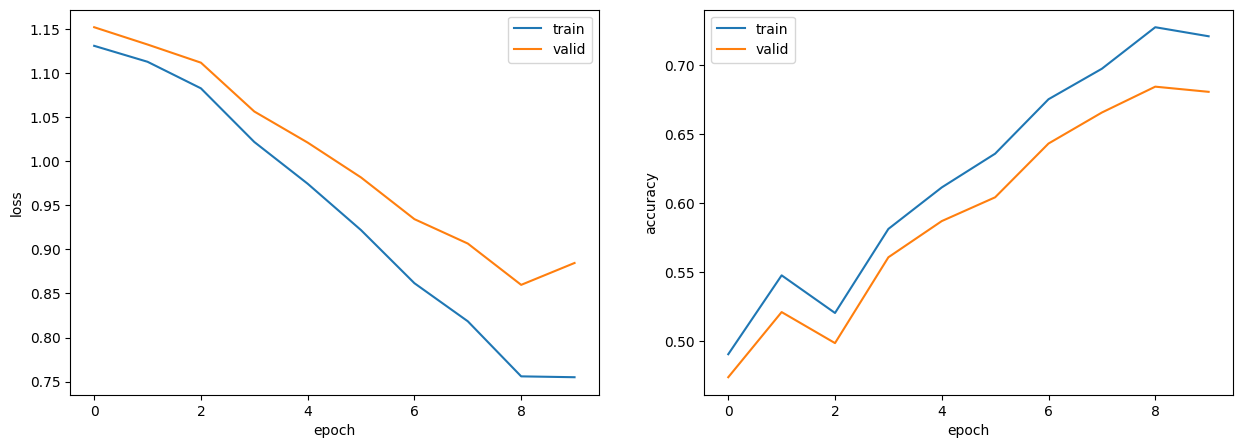

In [19]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

device = torch.device('cuda')

model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

visualize_logs(log, 87)
_, acc_train = calc_loss_acc(model, dataset_train, device)
_, acc_test = calc_loss_acc(model, dataset_test, device)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')


## 88. パラメータチューニング

<ipython-input-7-5f162c53d092>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.1385, accuracy_train: 0.4954, loss_valid: 1.1527, accuracy_valid: 0.4738, train_time: 0.6632sec
epoch: 2, loss_train: 1.1162, accuracy_train: 0.5543, loss_valid: 1.1310, accuracy_valid: 0.5374, train_time: 0.4660sec
epoch: 3, loss_train: 1.1144, accuracy_train: 0.5381, loss_valid: 1.1352, accuracy_valid: 0.5172, train_time: 0.4807sec
epoch: 4, loss_train: 1.0852, accuracy_train: 0.5792, loss_valid: 1.1053, accuracy_valid: 0.5576, train_time: 0.6979sec
epoch: 5, loss_train: 1.0625, accuracy_train: 0.5896, loss_valid: 1.0865, accuracy_valid: 0.5629, train_time: 0.5087sec
epoch: 6, loss_train: 1.0302, accuracy_train: 0.6233, loss_valid: 1.0565, accuracy_valid: 0.5981, train_time: 0.4831sec
epoch: 7, loss_train: 0.9920, accuracy_train: 0.6498, loss_valid: 1.0197, accuracy_valid: 0.6235, train_time: 0.6624sec
epoch: 8, loss_train: 1.0118, accuracy_train: 0.5826, loss_valid: 1.0578, accuracy_valid: 0.5554, train_time: 0.4791sec
epoch: 9, loss_train: 0.9287, accuracy_t

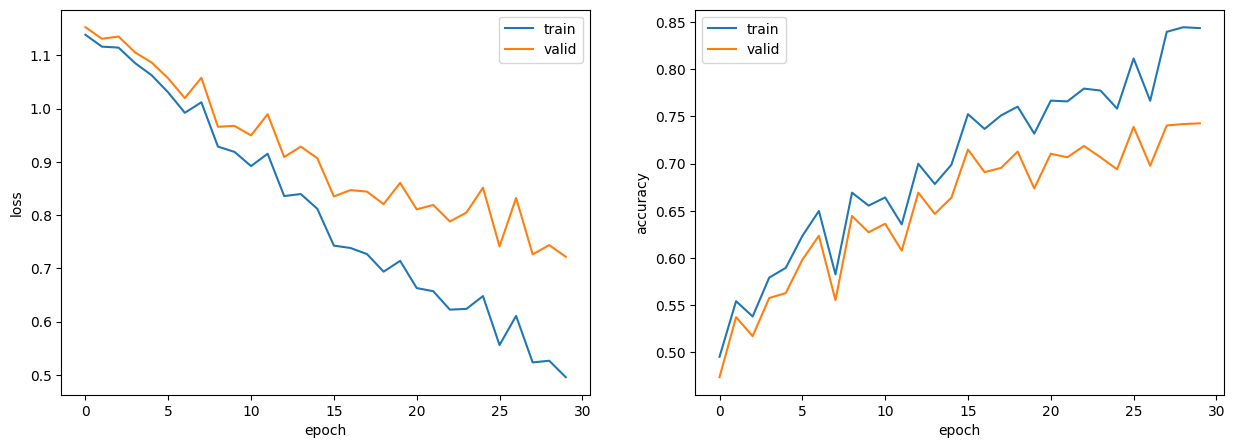

In [20]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 128 # 64 -> 128
NUM_EPOCHS = 30 # 10 -> 30

device = torch.device('cuda')

#def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False):
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

visualize_logs(log, 88)
_, acc_train = calc_loss_acc(model, dataset_train, device)
_, acc_test = calc_loss_acc(model, dataset_test, device)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')

## 89. 事前学習済み言語モデルからの転移学習

In [21]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-2ojsid5v
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-2ojsid5v
  Resolved https://github.com/huggingface/transformers to commit 0fdea8607d7e01eb0e38a1ebeb7feee30a22f0cf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.43.0.dev0-py3-none-any.whl size=9394961 sha256=9e7e3bc3d9f35da83892988f0cd80a4e772863041a3ea66a86d5f6a643a9d64b
  Stored in directory: /tmp/pip-ephem-wheel-cache-0bf_0952/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [22]:
!pip install transformers sentencepiece

In [23]:
import transformers
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda

In [24]:
class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer, max_len):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.x[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length = self.max_len,
            pad_to_max_length=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            "ids" : torch.LongTensor(ids),
            "mask" : torch.LongTensor(mask),
            "labels" : torch.Tensor(self.y[idx])
        }

In [25]:
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = NewsDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = NewsDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = NewsDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

ids: tensor([  101,  5035, 10556, 13639,  6182,  2319,  6661,  5789,  1011,  2489,
         2969,  2666,  1010,  1996,  4678,  3367,  1997,  2035, 10556,   102])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
labels: tensor([0., 1., 0., 0.])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [45]:
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = torch.nn.Dropout(drop_rate)
        self.fc = torch.nn.Linear(768, output_size)

    def forward(self, ids, mask, return_dict):
        _, out = self.bert(ids, attention_mask=mask,return_dict=return_dict)
        out = self.fc(self.drop(out))
        return out


In [42]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
          for data in loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(ids, mask, return_dict=False)

            loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1).cpu().numpy()
            labels = torch.argmax(labels, dim=-1).cpu().numpy()
            total += len(labels)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    model.to(device)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        for data in dataloader_train:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(ids, mask, return_dict=False)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    return {'train': log_train, 'valid': log_valid}

In [46]:
DROP_RATE = 0.2
OUTPUT_SIZE = 4
BATCH_SIZE = 64
NUM_EPOCHS = 8
LEARNING_RATE = 1e-5

model = BERTClass(DROP_RATE, OUTPUT_SIZE)
model.train()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

device = 'cuda' if cuda.is_available() else 'cpu'

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

epoch: 1, loss_train: 0.2272, accuracy_train: 0.9320, loss_valid: 0.2786, accuracy_valid: 0.9154, 75.8565sec
epoch: 2, loss_train: 0.1360, accuracy_train: 0.9619, loss_valid: 0.2420, accuracy_valid: 0.9222, 78.6214sec
epoch: 3, loss_train: 0.0899, accuracy_train: 0.9747, loss_valid: 0.2367, accuracy_valid: 0.9281, 74.7907sec
epoch: 4, loss_train: 0.0559, accuracy_train: 0.9871, loss_valid: 0.2288, accuracy_valid: 0.9386, 75.9855sec
epoch: 5, loss_train: 0.0434, accuracy_train: 0.9874, loss_valid: 0.2598, accuracy_valid: 0.9251, 75.7904sec
epoch: 6, loss_train: 0.0270, accuracy_train: 0.9936, loss_valid: 0.2648, accuracy_valid: 0.9319, 62.6162sec
epoch: 7, loss_train: 0.0204, accuracy_train: 0.9962, loss_valid: 0.2614, accuracy_valid: 0.9371, 63.9170sec
epoch: 8, loss_train: 0.0153, accuracy_train: 0.9968, loss_valid: 0.2731, accuracy_valid: 0.9356, 77.7185sec


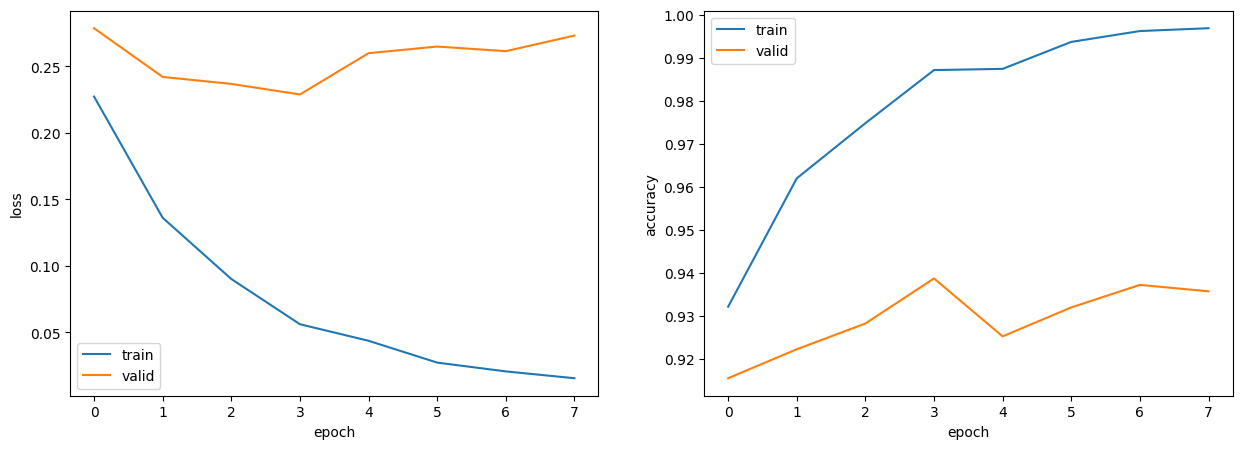

In [47]:
visualize_logs(log, 89)